<a href="https://colab.research.google.com/github/beelittlehoney/CCRNFLRL_PROJECT_COM221ML/blob/main/1K_Episode/%5BRL%5D2048_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Dependencies

In [1]:
!pip install git+https://github.com/Quentin18/gymnasium-2048.git --quiet
!pip install gymnasium torch numpy matplotlib imageio[ffmpeg] --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 12.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.1 which is incompatible.


# Imports

In [2]:
import random
import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import Video, display
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


# Dueling Double-DQN Network

In [3]:
class BaselineDQN(nn.Module):
    def __init__(self, state_size, action_size, hidden=128):
        super(BaselineDQN, self).__init__()
        # standard DQN architecture
        self.fc1 = nn.Linear(state_size, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, action_size) # Output layer for Q-values

    def forward(self, x):
        # accept both 1D and 2D tensors
        squeeze = False
        if x.dim() == 1:
            x = x.unsqueeze(0)
            squeeze = True

        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        q = self.fc3(x) # Output Q-values directly

        return q.squeeze(0) if squeeze else q

# Replay Buffer

In [4]:
class ReplayBuffer:
    def __init__(self, max_size=200_000):
        self.buffer = deque(maxlen=max_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.vstack(states),
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.vstack(next_states),
            np.array(dones, dtype=np.uint8),
        )

    def __len__(self):
        return len(self.buffer)

# Utility Functions

In [5]:
def preprocess_obs(obs, max_pow=16):
    board = np.array(obs, dtype=np.float32)
    with np.errstate(divide='ignore'):
        log_board = np.where(board > 0, np.log2(board), 0.0)
    norm = log_board / float(max_pow)
    return norm.flatten().astype(np.float32)

def safe_reset(env):
    out = env.reset()
    return out[0] if isinstance(out, tuple) else out

# Training Function with Early Termination

In [6]:
def train_dqn_improved(
    episodes=2000,
    gamma=0.99,
    lr=5e-4,
    batch_size=256,
    replay_capacity=200_000,
    start_learning_after=2000,
    target_update_every=100,
    train_updates_per_step=4,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay_steps=400_000,
    max_pow=16,
    max_steps_per_episode=1000,
    no_change_penalty=-0.02,
    max_tile_bonus_scale=1.0,
    max_stagnant_steps=100,        # <-- New: early termination threshold
):
    env = gym.make("gymnasium_2048:gymnasium_2048/TwentyFortyEight-v0", size=4, max_pow=max_pow)
    sample_obs = safe_reset(env)
    state_size = preprocess_obs(sample_obs, max_pow).shape[0]
    action_size = env.action_space.n

    q_net = BaselineDQN(state_size, action_size).to(device)
    target_net = BaselineDQN(state_size, action_size).to(device)
    target_net.load_state_dict(q_net.state_dict())
    optimizer = optim.Adam(q_net.parameters(), lr=lr)

    memory = ReplayBuffer(max_size=replay_capacity)
    epsilon = epsilon_start

    rewards_history = []
    best_max_tile_history = []

    total_steps = 0
    for ep in range(1, episodes + 1):
        obs = safe_reset(env)
        state = preprocess_obs(obs, max_pow)
        total_reward = 0.0
        done = False
        prev_max_tile = int(np.max(obs))
        steps = 0

        # new early termination trackers
        stagnant_moves = 0
        last_score = 0.0

        while not done and steps < max_steps_per_episode:
            # epsilon decay
            epsilon = max(epsilon_end, epsilon_start - (epsilon_start - epsilon_end) * (total_steps / epsilon_decay_steps))

            # choose action
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    qvals = q_net(torch.FloatTensor(state).to(device))
                    action = int(qvals.argmax().item())

            # take step
            next_obs, env_reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_state = preprocess_obs(next_obs, max_pow)

            # reward shaping
            r = float(env_reward)
            new_max_tile = int(np.max(next_obs))
            if new_max_tile > prev_max_tile:
                prev_log = 0 if prev_max_tile == 0 else np.log2(prev_max_tile)
                new_log = np.log2(new_max_tile)
                bonus = (new_log - prev_log) * max_tile_bonus_scale
                r += bonus
                prev_max_tile = new_max_tile
            if np.allclose(state, next_state):
                r += no_change_penalty

            memory.add((state, action, r, next_state, float(done)))
            state = next_state
            total_reward += r
            steps += 1
            total_steps += 1

            # check for stagnation (no score gain)
            if env_reward > 0:
                stagnant_moves = 0
                last_score += env_reward
            else:
                stagnant_moves += 1

            if stagnant_moves >= max_stagnant_steps:
                # terminate early if no improvement for too long
                done = True
                # optional mild penalty to signal stagnation
                total_reward -= 0.5
                break


            # train updates
            if len(memory) >= max(batch_size, start_learning_after):
                for _ in range(train_updates_per_step):
                    states_b, actions_b, rewards_b, next_states_b, dones_b = memory.sample(batch_size)
                    states_t = torch.FloatTensor(states_b).to(device)
                    actions_t = torch.LongTensor(actions_b).unsqueeze(1).to(device)
                    rewards_t = torch.FloatTensor(rewards_b).to(device)
                    next_states_t = torch.FloatTensor(next_states_b).to(device)
                    dones_t = torch.FloatTensor(dones_b).to(device)

                    q_values = q_net(states_t).gather(1, actions_t).squeeze(1)
                    with torch.no_grad():
                        # Double DQN: use online net to select action, target net to evaluate
                        next_actions = q_net(next_states_t).argmax(dim=1, keepdim=True)
                        next_q_values = target_net(next_states_t).gather(1, next_actions).squeeze(1)

                        targets = rewards_t + (1 - dones_t) * gamma * next_q_values

                    loss = nn.SmoothL1Loss()(q_values, targets)
                    optimizer.zero_grad()
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(q_net.parameters(), 10.0)
                    optimizer.step()

        rewards_history.append(total_reward)
        best_max_tile_history.append(prev_max_tile)

        if ep % target_update_every == 0:
            target_net.load_state_dict(q_net.state_dict())

        if ep % 10 == 0:
            avg10 = np.mean(rewards_history[-10:])
            avg_max_tile = np.mean(best_max_tile_history[-50:]) if len(best_max_tile_history) >= 50 else np.mean(best_max_tile_history)
            print(f"Ep {ep}/{episodes} | reward {total_reward:.2f} | avg10 {avg10:.2f} | eps {epsilon:.3f} | avg_max_tile_recent {avg_max_tile:.1f}")

    env.close()
    return q_net, rewards_history, best_max_tile_history

# Train the Agent

/usr/local/lib/python3.12/dist-packages/gymnasium_2048/envs/twenty_forty_eight.py:250: RuntimeWarning: overflow encountered in scalar add
  self.total_score += self.step_score


Ep 10/1000 | reward 993.48 | avg10 807.33 | eps 0.998 | avg_max_tile_recent 1.0
Ep 20/1000 | reward 2007.90 | avg10 1211.84 | eps 0.996 | avg_max_tile_recent 1.0
Ep 30/1000 | reward 1428.58 | avg10 942.99 | eps 0.994 | avg_max_tile_recent 1.0
Ep 40/1000 | reward 566.14 | avg10 1392.03 | eps 0.991 | avg_max_tile_recent 1.0
Ep 50/1000 | reward 610.30 | avg10 1006.56 | eps 0.989 | avg_max_tile_recent 1.0
Ep 60/1000 | reward 478.20 | avg10 1001.73 | eps 0.987 | avg_max_tile_recent 1.0
Ep 70/1000 | reward 717.78 | avg10 921.46 | eps 0.985 | avg_max_tile_recent 1.0
Ep 80/1000 | reward 1316.68 | avg10 1160.73 | eps 0.982 | avg_max_tile_recent 1.0
Ep 90/1000 | reward 594.02 | avg10 1071.56 | eps 0.980 | avg_max_tile_recent 1.0
Ep 100/1000 | reward 242.82 | avg10 1391.33 | eps 0.977 | avg_max_tile_recent 1.0
Ep 110/1000 | reward 1612.10 | avg10 1202.14 | eps 0.975 | avg_max_tile_recent 1.0
Ep 120/1000 | reward 633.96 | avg10 1207.83 | eps 0.973 | avg_max_tile_recent 1.0
Ep 130/1000 | reward 138

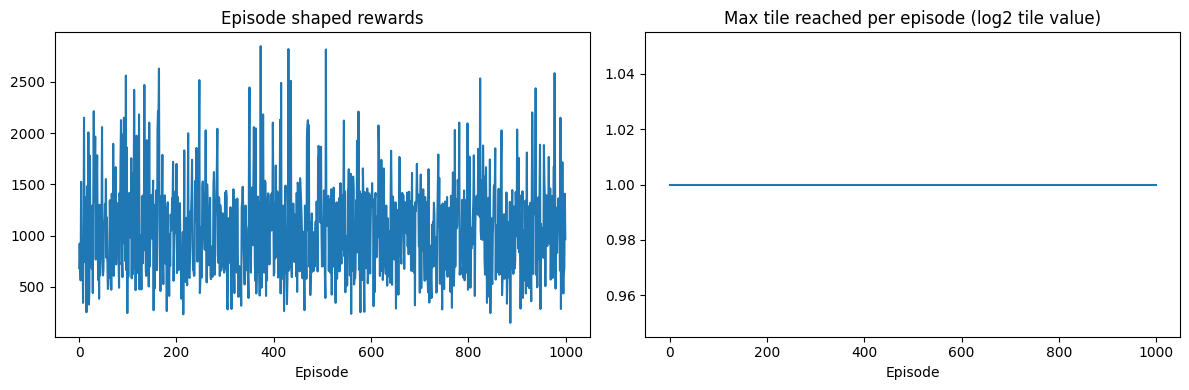

In [7]:
# Train with improved function. Increase episodes if you have time/GPU.
q_net, rewards, best_tile_hist = train_dqn_improved(
    episodes=1000,
    gamma=0.99,
    lr=5e-4,
    batch_size=256,
    replay_capacity=200_000,
    start_learning_after=5000,   # fill some buffer before learning
    target_update_every=50,
    train_updates_per_step=4,
    epsilon_decay_steps=600_000,
    max_pow=16,
    max_steps_per_episode=1000,
    no_change_penalty=-0.02,
    max_tile_bonus_scale=0.5,
)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(rewards)
plt.title("Episode shaped rewards")
plt.xlabel("Episode")
plt.subplot(1,2,2)
plt.plot(best_tile_hist)
plt.title("Max tile reached per episode (log2 tile value)")
plt.xlabel("Episode")
plt.tight_layout()
plt.show()

# Record Gameplay Video

In [8]:
import os
import torch
from gymnasium.wrappers import RecordVideo

# === Configuration ===
video_dir = "./videos"
num_episodes = 5          # Number of episodes to record
max_steps = 500           # Safety cap per episode
os.makedirs(video_dir, exist_ok=True)

# === Environment Setup ===
env = gym.make(
    "gymnasium_2048:gymnasium_2048/TwentyFortyEight-v0",
    size=4,
    max_pow=16,
    render_mode="rgb_array"
)

# === Record Multiple Episodes ===
for ep in range(1, num_episodes + 1):
    print(f"\n🎮 Recording Episode {ep}/{num_episodes}...")

    # Each episode gets its own subfolder for video files
    episode_dir = os.path.join(video_dir, f"episode_{ep}")
    os.makedirs(episode_dir, exist_ok=True)

    # Wrap environment to record this episode
    record_env = RecordVideo(env, episode_dir, episode_trigger=lambda x: True)

    obs = safe_reset(record_env)
    state = preprocess_obs(obs)
    done = False
    total_reward = 0

    # Track stagnation to stop early if no score improvement
    stagnant_steps = 0
    last_score = 0

    for step in range(max_steps):
        with torch.no_grad():
            action = torch.argmax(q_net(torch.FloatTensor(state).to(device))).item()
        next_obs, reward, terminated, truncated, info = record_env.step(action)
        total_reward += reward
        state = preprocess_obs(next_obs)
        done = terminated or truncated

        current_score = info.get("score", 0)
        if current_score <= last_score:
            stagnant_steps += 1
        else:
            stagnant_steps = 0
        last_score = current_score

        # End episode early if stagnant for too long
        if stagnant_steps > 100:
            print(f"🛑 Episode {ep} ended early (no score improvement).")
            break

        if done:
            break

    record_env.close()
    print(f"✅ Saved video for Episode {ep} | Total Reward: {total_reward:.2f}")

env.close()
print("\n🎬 All episodes recorded! Check the './videos' folder.")


🎮 Recording Episode 1/5...


/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/videos/episode_1 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


🛑 Episode 1 ended early (no score improvement).


/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"


Moviepy - Building video /content/videos/episode_1/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/episode_1/rl-video-episode-0.mp4



/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/videos/episode_2 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Done !
Moviepy - video ready /content/videos/episode_1/rl-video-episode-0.mp4
✅ Saved video for Episode 1 | Total Reward: 100.00

🎮 Recording Episode 2/5...
🛑 Episode 2 ended early (no score improvement).
Moviepy - Building video /content/videos/episode_2/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/episode_2/rl-video-episode-0.mp4



/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/videos/episode_3 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Done !
Moviepy - video ready /content/videos/episode_2/rl-video-episode-0.mp4
✅ Saved video for Episode 2 | Total Reward: 24.00

🎮 Recording Episode 3/5...
🛑 Episode 3 ended early (no score improvement).
Moviepy - Building video /content/videos/episode_3/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/episode_3/rl-video-episode-0.mp4



/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/videos/episode_4 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Done !
Moviepy - video ready /content/videos/episode_3/rl-video-episode-0.mp4
✅ Saved video for Episode 3 | Total Reward: 0.00

🎮 Recording Episode 4/5...
🛑 Episode 4 ended early (no score improvement).
Moviepy - Building video /content/videos/episode_4/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/episode_4/rl-video-episode-0.mp4



/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /content/videos/episode_5 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Done !
Moviepy - video ready /content/videos/episode_4/rl-video-episode-0.mp4
✅ Saved video for Episode 4 | Total Reward: 24.00

🎮 Recording Episode 5/5...
🛑 Episode 5 ended early (no score improvement).
Moviepy - Building video /content/videos/episode_5/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/episode_5/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/episode_5/rl-video-episode-0.mp4
✅ Saved video for Episode 5 | Total Reward: 4.00

🎬 All episodes recorded! Check the './videos' folder.


# Watch the Recorded Video

In [9]:
import os
from IPython.display import Video, display
import glob

# Find all MP4 videos inside the videos directory (including subfolders)
video_files = sorted(
    glob.glob(os.path.join(video_dir, "**", "*.mp4"), recursive=True),
    key=os.path.getmtime
)

# Display all recorded videos (or just latest N if you prefer)
if video_files:
    print(f"🎬 Found {len(video_files)} recorded episode(s).")
    for vid_path in video_files:
        print(f"\nPlaying: {vid_path}")
        display(Video(vid_path, embed=True))
else:
    print(f"No videos found in '{video_dir}'.")

🎬 Found 5 recorded episode(s).

Playing: ./videos/episode_1/rl-video-episode-0.mp4



Playing: ./videos/episode_2/rl-video-episode-0.mp4



Playing: ./videos/episode_3/rl-video-episode-0.mp4



Playing: ./videos/episode_4/rl-video-episode-0.mp4



Playing: ./videos/episode_5/rl-video-episode-0.mp4
